# IMPORTS

In [ ]:
import pandas as pd
import networkx as nx 
import matplotlib.pyplot as plt
from networkx.algorithms.community.centrality import girvan_newman
from sklearn import preprocessing
import os
import random
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches


# DATA LOADING

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [ ]:
cb = '/content/drive/MyDrive/Capstone/COMBINED DATA/COBRE Binary/'
cw = '/content/drive/MyDrive/Capstone/COMBINED DATA/COBRE Weighted/'

ub = '/content/drive/MyDrive/Capstone/COMBINED DATA/UCLA Binary v2/'
uw = '/content/drive/MyDrive/Capstone/COMBINED DATA/UCLA Weighted v2/'

binary_features = '/content/drive/MyDrive/Capstone/Graph properties /Binary local feature files/'
weighted_features = '/content/drive/MyDrive/Capstone/Graph properties /Weighted local feature files/'

uwa = '/content/drive/MyDrive/Capstone/Data Augmentation/UCLA Augmented/'
uba = '/content/drive/MyDrive/Capstone/Data Augmentation/UCLA Augmented Binary/UCLA Binary 0_2/'

weighted_features_aug = '/content/drive/MyDrive/Capstone/Data Augmentation/Local Weighted features - UCLA Aug/'
weighted_features_aug2 = ''
binary_features_aug = '/content/drive/MyDrive/Capstone/Data Augmentation/Local Binary features -  UCLA Aug/'

In [ ]:
# Labels
combined_phenotype='/content/drive/MyDrive/Capstone/COMBINED DATA/phenotypic_data.csv'

labels_mappings= pd.read_csv(combined_phenotype)
labels_mappings

,Subject,Subject Type,Label
0,40013,Control,0
1,40014,Control,0
2,40017,Control,0
3,40018,Control,0
4,40019,Control,0
...,...,...,...
587,3167,Control,1
588,3168,Control,1
589,3169,Patient,1
590,3170,Patient,1


In [ ]:
graphs_dir = [ub, uba]
feat_dir = [(weighted_features, "weighted_node_features_"), (binary_features, "binary_node_features_")]
aug_feat_dir = [(weighted_features_aug, "weighted_node_features_"), (binary_features_aug, "binary_node_features_")]
# (weighted_features, "weighted_node_features_"), 

In [ ]:
class SyntheticDataset():
    def __init__(self, gclasses, dim_nfeats):
        self.gclasses = gclasses
        self.dim_nfeats = dim_nfeats
        self.process()
        
    def process(self):
        self.graphs = []
        self.labels = []
        
        # Graph creation
        for ind in range(len(graphs_dir)):
          directory = graphs_dir[ind]
          for file in os.listdir(directory):
            if '(' in file:
              continue 
            if file.endswith('.csv'):
              if (directory == cb):
                subject = file[13:18]
              elif (directory == cw):
                  subject = file[15:20]
              elif (directory == ub):
                  subject = file[12:16]
              elif (directory == uw):
                  subject = file[14:18]
              elif (directory == uwa):
                  subject = file[14:18]
              elif (directory == uba):
                  subject = file[12:16]
                  if int(subject) < 3122:
                    continue
              else:
                  print("INVALID DIRECTORY")
                  exit(0)
 

              # APPENDING LABEL
              mask = labels_mappings['Subject'] == int(subject)
              self.labels.append(labels_mappings[mask]['Label'].values[0])

              # APPENDING CORRESPONDING GRAPH
              df = pd.read_csv(directory+'/'+file, header=None)
              df = df.fillna(0)
              G = nx.from_pandas_adjacency(df)          

              # Features
              if directory == uwa or directory == uba:
                if len(feat_dir) == 1:
                  node_data = pd.read_csv(aug_feat_dir[0][0]+feat_dir[0][1]+str(subject)+'.csv')
                  node_data = node_data.drop(['Unnamed: 0'], axis=1, errors='ignore')
                else:
                  node_data_1 = pd.read_csv(aug_feat_dir[0][0]+feat_dir[0][1]+str(subject)+'.csv')
                  node_data_2 = pd.read_csv(aug_feat_dir[1][0]+feat_dir[1][1]+str(subject)+'.csv')
                  node_data_1 = node_data_1.drop(['Unnamed: 0'], axis=1, errors='ignore')
                  node_data_2 = node_data_2.drop(['Unnamed: 0'], axis=1, errors='ignore')
                  node_data = pd.merge(node_data_1, node_data_2, how = "inner", left_index=True, right_index=True)
              else:
                if len(feat_dir) == 1:
                  node_data = pd.read_csv(feat_dir[0][0]+feat_dir[0][1]+str(subject)+'.csv')
                  node_data = node_data.drop(['Unnamed: 0'], axis=1, errors='ignore')
                else:
                  node_data_1 = pd.read_csv(feat_dir[0][0]+feat_dir[0][1]+str(subject)+'.csv')
                  node_data_2 = pd.read_csv(feat_dir[1][0]+feat_dir[1][1]+str(subject)+'.csv')
                  node_data_1 = node_data_1.drop(['Unnamed: 0'], axis=1, errors='ignore')
                  node_data_2 = node_data_2.drop(['Unnamed: 0'], axis=1, errors='ignore')
                  node_data = pd.merge(node_data_1, node_data_2, how = "inner", left_index=True, right_index=True)

              node_data = node_data.drop(['subgraph centrality'], axis=1, errors='ignore')
        

              # Standardisation
              cols = list(node_data)
              scaler = preprocessing.StandardScaler().fit(node_data)
              node_data = scaler.transform(node_data)
              node_data = pd.DataFrame(node_data, columns = cols)


              dict_list = dict()
              for index, rows in node_data.iterrows():
                  dict_list[index] = list(rows)

              count=0
              for col in node_data:
                  nx.set_node_attributes(G, dict_list[count], 'attrs')
                  count+=1
              
              self.graphs.append(G)

              
        # zipped = list(zip(self.graphs, self.labels))
        # random.shuffle(zipped)
        # self.graphs.clear()
        # self.labels.clear()
        # for i in range(len(zipped)):
        #   self.graphs.append(zipped[i][0])
        #   self.labels.append(zipped[i][1])

        
    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]
    
    def __len__(self):
        return len(self.graphs)

In [ ]:
dataset = SyntheticDataset(2, 25)

In [ ]:
len(dataset)

221

In [ ]:
dataset.labels.count(1)

96

In [ ]:
dataset.labels.count(0)

125

In [ ]:
aal_path = '/content/drive/MyDrive/Capstone/COMBINED DATA/AAL mapping/CONN ROIS - Mappings.csv'
aal = pd.read_csv(aal_path)
aal

,ROI,Region
0,0,"DefaultMode.MPFC (1,55,-3)"
1,1,"DefaultMode.LP (L) (-39,-77,33)"
2,2,"DefaultMode.LP (R) (47,-67,29)"
3,3,"DefaultMode.PCC (1,-61,38)"
4,4,"SensoriMotor.Lateral (L) (-55,-12,29)"
...,...,...
159,159,Ver6 (Vermis 6)
160,160,Ver7 (Vermis 7)
161,161,Ver8 (Vermis 8)
162,162,Ver9 (Vermis 9)


# COMMUNITY DETECTION

## GIRVAN NEWMANN


### PRELIMINARY

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163], [142]]


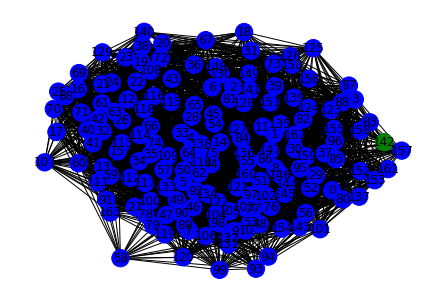

0


In [ ]:
G = dataset[0][0]
communities = girvan_newman(G)

node_groups = []
for com in next(communities):
  node_groups.append(list(com))

print(node_groups)

color_map = []
for node in G:
    if node in node_groups[0]:
        color_map.append('blue')
    else: 
        color_map.append('green')  
nx.draw(G, node_color=color_map, with_labels=True)
plt.show()

print(dataset[0][1])

In [ ]:
G = dataset[0][0]
communities = girvan_newman(G)

node_groups = []
for com in next(communities):
  node_groups.append(list(com))
node_groups

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  158,
  15

### MAIN

#### 2 communities

In [ ]:
cooc_schiz = np.zeros((164,164))
cooc_control = np.zeros((164,164))

In [ ]:
for i in range(len(dataset)):
  print(i)
  sch = dataset[i][1]
  communities = girvan_newman(dataset[i][0])

  node_groups = []
  for com in next(communities):
    node_groups.append(list(com))

  if sch:
    for l in node_groups:
      for x in range(len(l)):
        for y in range(x+1, len(l)):
          cooc_schiz[l[x]][l[y]] += 1
          cooc_schiz[l[x]][l[y]] += 1
  else:
    for l in node_groups:
      for x in range(len(l)):
        for y in range(x+1, len(l)):
          cooc_control[l[x]][l[y]] += 1
          cooc_control[l[y]][l[x]] += 1
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114


In [ ]:
cooc_control

In [ ]:
cooc_schiz

In [ ]:
confidence = 0.95

In [ ]:
cooccurance_schiz_bool = np.zeros((164,164))
cooccurance_control_bool = np.zeros((164,164))

In [ ]:
for x in range(164):
  for y in range(x+1, 164):
    if cooc_schiz[x][y] > dataset.labels.count(1)*confidence:
      cooccurance_schiz_bool[x][y] += 1
      cooccurance_schiz_bool[y][x] += 1

In [ ]:
for x in range(164):
  for y in range(x+1, 164):
    if cooc_control[x][y] > dataset.labels.count(0)*confidence:
      cooccurance_control_bool[x][y] += 1
      cooccurance_control_bool[y][x] += 1

In [ ]:
pd.DataFrame(cooccurance_schiz_bool)

In [ ]:
pd.DataFrame(cooccurance_control_bool)

In [ ]:
count = 0
for x in range(164):
  for y in range(x+1, 164):
    if cooccurance_schiz_bool[x][y] != cooccurance_control_bool[x][y]:
      count += 1
      print(x, aal[aal['ROI'] == x]['Region'].item(), y, aal[aal['ROI'] == y]['Region'].item(), sep='\t\t')
print(count)

#### 4 communities

In [ ]:
cooc_schiz = np.zeros((164,164))
cooc_control = np.zeros((164,164))

In [ ]:
for i in range(len(dataset)):
  print(i)
  sch = dataset[i][1]
  communities = girvan_newman(dataset[i][0])

  next(communities)
  next(communities)

  node_groups = []
  for com in next(communities):
    node_groups.append(list(com))

  if sch:
    for l in node_groups:
      for x in range(len(l)):
        for y in range(x+1, len(l)):
          cooc_schiz[l[x]][l[y]] += 1
          cooc_schiz[l[x]][l[y]] += 1
  else:
    for l in node_groups:
      for x in range(len(l)):
        for y in range(x+1, len(l)):
          cooc_control[l[x]][l[y]] += 1
          cooc_control[l[y]][l[x]] += 1
    

In [ ]:
cooc_control

In [ ]:
cooc_schiz

In [ ]:
confidence = 0.95

In [ ]:
cooccurance_schiz_bool = np.zeros((164,164))
cooccurance_control_bool = np.zeros((164,164))

In [ ]:
for x in range(164):
  for y in range(x+1, 164):
    if cooc_schiz[x][y] > dataset.labels.count(1)*confidence:
      cooccurance_schiz_bool[x][y] += 1
      cooccurance_schiz_bool[y][x] += 1

In [ ]:
for x in range(164):
  for y in range(x+1, 164):
    if cooc_control[x][y] > dataset.labels.count(0)*confidence:
      cooccurance_control_bool[x][y] += 1
      cooccurance_control_bool[y][x] += 1

In [ ]:
pd.DataFrame(cooccurance_schiz_bool)

In [ ]:
pd.DataFrame(cooccurance_control_bool)

In [ ]:
count = 0
for x in range(164):
  for y in range(x+1, 164):
    if cooccurance_schiz_bool[x][y] != cooccurance_control_bool[x][y]:
      count += 1
      print(x, aal[aal['ROI'] == x]['Region'].item(), y, aal[aal['ROI'] == y]['Region'].item(), sep='\t\t')
print(count)

## SPECTRAL CLUSTERING

In [ ]:
# Class to perform spectral clustering for k clusters, given k

class SpectralClustering:
    
    def __init__(self, G):
        # Initialize the graph, nodes and the normalized Laplacian

        self.graph = G
        self.normalized_laplacian = nx.linalg.normalized_laplacian_matrix(G).toarray()
        self.nodes = G.nodes()

    def compute_eigenspace(self):
        # Compute the eigenvalues and the eigenvectors using Numpy and sort them in ascending order 

        eigenvalues, eigenvectors = np.linalg.eig(self.normalized_laplacian)

        sort_index = np.argsort(eigenvalues) # Returns the list of indices that would sort the array
        sorted_eigenvectors = eigenvectors[:, sort_index]

        return sorted_eigenvectors

    def fit(self, k):
        """
        Step 1: Extract the k eigen vectors and stack them vertically to form a matrix (i.e each vector is a column)
        Step 2: Every row of this matrix represents the features of the respective nodes of the graph
        Step 3: Perform K-Means clustering on this dataset to identify k clusters

        """
        eigenvectors = self.compute_eigenspace()
        k_eigenvectors = np.array(eigenvectors)[:,:k]
        dataset = pd.DataFrame(k_eigenvectors, index=self.nodes)

        # print(dataset)

        k_means_clusters = KMeans(n_clusters = k, random_state=42)
        self.clusters = k_means_clusters.fit(k_eigenvectors)
        
    def predict_labels(self):
        # Returns the labels 
        return self.clusters.labels_

    def assign_labels(self, labels):
        # Helper to assign the labels as node attributes
        for i,node in enumerate(self.graph.nodes()):
            self.graph.nodes[node]['label'] = labels[i]

    def plot_graph(self, n_clusters, title='Graph after Spectral Clustering'):
        # Plots the graph 

        labels = self.clusters.labels_
        self.assign_labels(labels)

        colour_list = ['lightgreen','red','yellow', 'magenta','lightblue','grey']
        sampled_colours = dict(zip(set(labels),random.sample(colour_list, n_clusters)))

        legend_handles = []
        for label, color in sampled_colours.items():
            colour_handle = mpatches.Patch(color=color, label=label)
            legend_handles.append(colour_handle)

        colours = [sampled_colours[i] for i in labels]

        pos_fr = nx.fruchterman_reingold_layout(self.graph)
        plt.figure(figsize=(16,14))
        plt.title(title)
        plt.legend(handles=legend_handles)
        nx.draw(self.graph, pos=pos_fr, node_size=700, node_color=colours, with_labels=True)
        plt.show()

### PRELIMINARY

In [ ]:
# Performing Spectral Clustering on the graph
k = 4

G = dataset[0][0]
SpecClust = SpectralClustering(G)
SpecClust.fit(k)
clustering_labels = SpecClust.predict_labels()
# print(labels)

for i,node in enumerate(G.nodes()):
    G.nodes[node]['label'] = clustering_labels[i]

colour_map = ['']*len(clustering_labels)
for i, label in enumerate(clustering_labels):
    if label == 0:
        colour_map[i] = 'lightgreen'
    else:
        colour_map[i] = "red"

# nx.draw(CG, with_labels=True, node_color=colour_map)
SpecClust.plot_graph(k, title="Graph after Spectral Clustering")

In [ ]:
# Performing Spectral Clustering on the graph
k = 2
schiz_comm = dict()
control_comm = dict()

for i in range(164):
  schiz_comm[i] = {0:0, 1:0}
  control_comm[i] = {0:0, 1:0}

for i in dataset:
  G = i[0]
  sch = i[1]
  SpecClust = SpectralClustering(G)
  SpecClust.fit(k)
  clustering_labels = SpecClust.predict_labels()

  if sch:
    for i in range(len(clustering_labels)):
      schiz_comm[i][clustering_labels[i]] += 1
  else:
    for i in range(len(clustering_labels)):
      control_comm[i][clustering_labels[i]] += 1

In [ ]:
schiz_comm

In [ ]:
control_comm

### MAIN

In [ ]:
sc_results = dict()

In [ ]:
confidence = 0.95

**Remember, schiz has less subjects than control**

In [ ]:
k = 2

In [ ]:
cooccurance_schiz = np.zeros((164,164))
cooccurance_control = np.zeros((164,164))

In [ ]:
# Performing Spectral Clustering on the graph

for i in dataset:
  G = i[0]
  sch = i[1]
  SpecClust = SpectralClustering(G)
  SpecClust.fit(k)
  clustering_labels = SpecClust.predict_labels()

  if sch:
    for x in range(len(clustering_labels)):
      for y in range(x+1, len(clustering_labels)):
        if clustering_labels[x] == clustering_labels[y]:
          cooccurance_schiz[x][y] += 1
          cooccurance_schiz[y][x] += 1
  else:
    for x in range(len(clustering_labels)):
      for y in range(x+1, len(clustering_labels)):
        if clustering_labels[x] == clustering_labels[y]:
          cooccurance_control[x][y] += 1
          cooccurance_control[y][x] += 1

In [ ]:
cooccurance_schiz

In [ ]:
cooccurance_control

In [ ]:
cooccurance_schiz_bool = np.zeros((164,164))
cooccurance_control_bool = np.zeros((164,164))

In [ ]:
for x in range(164):
  for y in range(x+1, 164):
    if cooccurance_schiz[x][y] > dataset.labels.count(1)*confidence:
      cooccurance_schiz_bool[x][y] += 1
      cooccurance_schiz_bool[y][x] += 1

In [ ]:
for x in range(164):
  for y in range(x+1, 164):
    if cooccurance_control[x][y] > dataset.labels.count(0)*confidence:
      cooccurance_control_bool[x][y] += 1
      cooccurance_control_bool[y][x] += 1

In [ ]:
pd.DataFrame(cooccurance_schiz_bool)

In [ ]:
pd.DataFrame(cooccurance_control_bool)

In [ ]:
count = 0
for x in range(164):
  for y in range(x+1, 164):
    if cooccurance_schiz_bool[x][y] != cooccurance_control_bool[x][y]:
      count += 1
      print(x, aal[aal['ROI'] == x]['Region'].item(), y, aal[aal['ROI'] == y]['Region'].item(), sep='\t\t')
print(count)

In [ ]:
sc_results[k] = count

In [ ]:
sc_results

**ANALYSIS**  
  
  
k = 3  
90% CI  

4	5:	SensoriMotor.Lateral (L) (-55,-12,29),	SensoriMotor.Lateral (R) (56,-10,29)  
*Motor: Lack of motor skill is a symptom of schiz*  
  
7	97:	Visual.Medial (2,-79,12), LG r (Lingual Gyrus Right)  
*LG: Visuals, especially reading letters. Also logical orders and visual memories.*  
   
20 67:	DorsalAttention.IPS (L)  (-39,-43,52), SPL l (Superior Parietal Lobule Left)   
*SPL: attention and visuospatial perception, including the representation and manipulation of objects, DA IPS: voluntary orienting of visuospatial attention, selection of stimuli based on current internal goals or expectations and pre-existing information about presented stimuli.*  
  
25	72:	FrontoParietal.PPC (R)  (52,-52,45),	AG r (Angular Gyrus Right)  
31 139:	Cerebellar.Posterior (0,-79,-32), Cereb1 r (Cerebelum Crus1 Right)  
105	106: OFusG r (Occipital Fusiform Gyrus Right),	OFusG l (Occipital Fusiform Gyrus Left)  
117	118: PT r (Planum Temporale Right), PT l (Planum Temporale Left)  
      
    
        
k = 2  
95% CI  
  
31		Cerebellar.Posterior (0,-79,-32)		140		Cereb2 l (Cerebelum Crus2 Left)   
34		IC r (Insular Cortex Right)		35		IC l (Insular Cortex Left)  
44		PreCG r (Precentral Gyrus Right)		45		PreCG l (Precentral Gyrus Left)  
109		CO r (Central Opercular Cortex Right)		110		CO l (Central Opercular Cortex Left)  
109		CO r (Central Opercular Cortex Right)		118		PT l (Planum Temporale Left)  
110		CO l (Central Opercular Cortex Left)		117		PT r (Planum Temporale Right)  
112		PO l (Parietal Operculum Cortex Left)		118		PT l (Planum Temporale Left)  
113		PP r (Planum Polare Right)		114		PP l (Planum Polare Left)  
117		PT r (Planum Temporale Right)		118		PT l (Planum Temporale Left)  
